# 2a — Object Detection: SSD / SSDLite

**Method implemented in this notebook:**  
- **SSDLite** (TorchVision, PyTorch)

## Project dataset structure
- `./signs.json`
- `./signs_coco/images/` (`.jpg` / `.jpeg`)
- `./signs_coco/result.json` (COCO annotations)

## What this notebook does
1. Setup + deterministic split
2. Load COCO + quick sanity checks
3. Build TorchVision-compatible detection dataset + dataloaders
4. Train **SSDLite320 MobileNetV3-Large**
5. Evaluate with COCO-style mAP (TorchMetrics)
6. Save checkpoint + simple inference helpers
7. Qualitative predictions + quick demo

In [13]:
from pathlib import Path
import os, sys, random
import numpy as np
import torch
import torchvision
import torch.multiprocessing as mp

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

try:
    mp.set_sharing_strategy("file_descriptor")
except RuntimeError:
    pass

REPRODUCIBLE = False
torch.backends.cudnn.deterministic = REPRODUCIBLE
torch.backends.cudnn.benchmark = not REPRODUCIBLE

if torch.cuda.is_available():
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    except Exception:
        pass

try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ["TMPDIR"] = "/tmp"
os.environ["TMP"] = "/tmp"
os.environ["TEMP"] = "/tmp"

PROJECT_ROOT = Path(".").resolve()
COCO_ANN = PROJECT_ROOT / "signs_coco" / "result.json"
IMAGES_DIR = PROJECT_ROOT / "signs_coco" / "images"

assert COCO_ANN.exists(), f"Missing: {COCO_ANN}"
assert IMAGES_DIR.exists(), f"Missing: {IMAGES_DIR}"

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.11.14
Torch: 2.8.0+cu128
TorchVision: 0.23.0+cu128
Device: cuda
GPU: NVIDIA GeForce RTX 2070 SUPER


In [14]:
import json
from collections import Counter

coco = json.loads(COCO_ANN.read_text(encoding="utf-8"))

images = coco.get("images", [])
annotations = coco.get("annotations", [])
categories = coco.get("categories", [])

cat_id_to_name = {c["id"]: c["name"] for c in categories}

print("#images:", len(images))
print("#annotations:", len(annotations))
print("#categories:", len(categories))

cnt = Counter(a["category_id"] for a in annotations)
print("\nTop-10 classes:")
for cid, n in cnt.most_common(10):
    print(f"{cat_id_to_name.get(cid, cid)}: {n}")

#images: 602
#annotations: 899
#categories: 38

Top-10 classes:
No Entry (One Way): 179
Pedestrian Crossing: 122
Stop: 92
Blind-Spot Mirror (Convex): 85
No Turn (left/right): 67
Turn (left/right): 62
Speed Limit: 52
Roundabout Ahead: 45
No Stopping: 41
Give way: 38


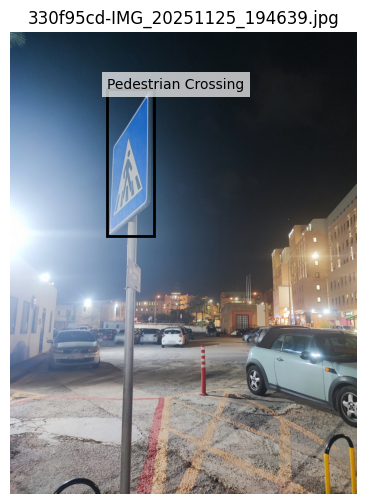

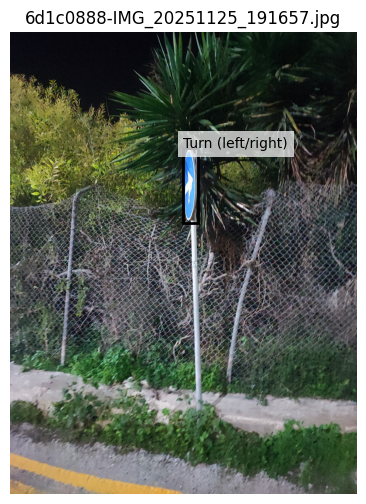

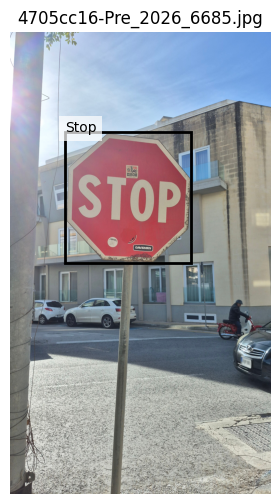

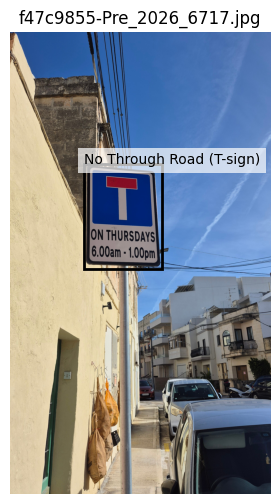

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from PIL import Image

img_id_to_file = {im["id"]: im["file_name"] for im in images}

img_to_anns = defaultdict(list)
for a in annotations:
    img_to_anns[a["image_id"]].append(a)

image_ids_with_anns = [im["id"] for im in images if im["id"] in img_to_anns and len(img_to_anns[im["id"]]) > 0]
rng = random.Random(SEED)
sample_ids = rng.sample(image_ids_with_anns, k=min(4, len(image_ids_with_anns)))

for iid in sample_ids:
    fn = img_id_to_file[iid]
    p = IMAGES_DIR / fn
    if not p.exists():
        p = IMAGES_DIR / Path(fn).name
    if not p.exists():
        continue

    img = Image.open(p).convert("RGB")
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(Path(fn).name)

    for a in img_to_anns.get(iid, []):
        x, y, w, h = a["bbox"]
        ax.add_patch(patches.Rectangle((x, y), w, h, fill=False, linewidth=2))
        name = cat_id_to_name.get(a["category_id"], str(a["category_id"]))
        ax.text(
            x, max(0, y - 3),
            name,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    plt.show()

In [16]:
import json

SPLIT_SEED = 42
TRAIN_FRACTION = 0.8

run_dir = PROJECT_ROOT / "runs" / f"2a_ssdlite"
split_dir = run_dir / "splits"
split_dir.mkdir(parents=True, exist_ok=True)

train_json_path = split_dir / "train_coco.json"
val_json_path   = split_dir / "val_coco.json"

rng = np.random.default_rng(SPLIT_SEED)
all_images = list(images)
rng.shuffle(all_images)

n_train = int(len(all_images) * TRAIN_FRACTION)
train_images = all_images[:n_train]
val_images   = all_images[n_train:]

train_ids = {im["id"] for im in train_images}
val_ids   = {im["id"] for im in val_images}

train_anns = [a for a in annotations if a["image_id"] in train_ids]
val_anns   = [a for a in annotations if a["image_id"] in val_ids]

def _write_subset(path: Path, imgs, anns):
    out = {"images": imgs, "annotations": anns, "categories": categories}
    if coco.get("info") is not None:
        out["info"] = coco["info"]
    if coco.get("licenses") is not None:
        out["licenses"] = coco["licenses"]
    with open(path, "w", encoding="utf-8") as f:
        json.dump(out, f)

_write_subset(train_json_path, train_images, train_anns)
_write_subset(val_json_path,   val_images,   val_anns)

print("run_dir:", run_dir)
print("train:", len(train_images), "images |", len(train_anns), "anns")
print("val  :", len(val_images),   "images |", len(val_anns),   "anns")

run_dir: /home/yukkami/cv/runs/2a_ssdlite
train: 481 images | 726 anns
val  : 121 images | 173 anns


In [17]:
import json

def normalize_filenames(coco_path: Path) -> int:
    with open(coco_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    updated = 0
    for im in data.get("images", []):
        fn = im.get("file_name", "")
        if (IMAGES_DIR / fn).exists():
            continue
        base = Path(fn).name
        if (IMAGES_DIR / base).exists():
            im["file_name"] = base
            updated += 1

    with open(coco_path, "w", encoding="utf-8") as f:
        json.dump(data, f)

    return updated

print("updated train:", normalize_filenames(train_json_path))
print("updated val  :", normalize_filenames(val_json_path))

updated train: 481
updated val  : 121


In [18]:
from pathlib import Path
from typing import Any, Dict, List, Tuple

import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from torchvision.io import read_image, ImageReadMode

sorted_cat_ids = sorted([c["id"] for c in categories])
coco_cat_id_to_contig = {cid: i + 1 for i, cid in enumerate(sorted_cat_ids)}
contig_to_name = {i + 1: cat_id_to_name[cid] for i, cid in enumerate(sorted_cat_ids)}
NUM_CLASSES = len(sorted_cat_ids) + 1

print("NUM_CLASSES (incl background):", NUM_CLASSES)
print("Example mapping COCO->contig:", list(coco_cat_id_to_contig.items())[:5])

class CocoDetectionForTorchvision(Dataset):
    def __init__(self, ann_file: Path, images_dir: Path, transforms=None):
        self.coco = COCO(str(ann_file))
        self.images_dir = images_dir
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx: int):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]

        img_path = self.images_dir / file_name
        if not img_path.exists():
            img_path = self.images_dir / Path(file_name).name
        if not img_path.exists():
            raise FileNotFoundError(f"Image not found for COCO id={img_id}: {file_name}")

        img = read_image(str(img_path), mode=ImageReadMode.RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        areas = []
        for a in anns:
            x, y, w, h = a["bbox"]
            if w <= 0 or h <= 0:
                continue
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_cat_id_to_contig[a["category_id"]])
            areas.append(w * h)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id], dtype=torch.int64),
            "area": areas,
            "iscrowd": torch.zeros((labels.shape[0],), dtype=torch.int64),
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

class SimpleDetTransforms:
    def __init__(self, train: bool):
        self.train = train

    def __call__(self, img, target):
        return img, target

def detection_collate_fn(batch: List[Tuple[torch.Tensor, Dict[str, Any]]]):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_ds_ssd = CocoDetectionForTorchvision(train_json_path, IMAGES_DIR, transforms=SimpleDetTransforms(train=True))
val_ds_ssd   = CocoDetectionForTorchvision(val_json_path,   IMAGES_DIR, transforms=SimpleDetTransforms(train=False))

BATCH_SIZE = 4 if device.type == "cuda" else 2
NUM_WORKERS = 1

train_loader_ssd = DataLoader(
    train_ds_ssd,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=detection_collate_fn,
    pin_memory=(device.type == "cuda"),
)

val_loader_ssd = DataLoader(
    val_ds_ssd,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=detection_collate_fn,
    pin_memory=(device.type == "cuda"),
)

print("SSD/SSDLite loaders ready.")
print("  train batches:", len(train_loader_ssd))
print("  val   batches:", len(val_loader_ssd))

imgs, targs = next(iter(train_loader_ssd))
print("Batch image tensor dtype:", imgs[0].dtype, "shape:", imgs[0].shape)
print("Batch target keys:", targs[0].keys())
print("First sample boxes:", targs[0]["boxes"].shape, "| labels:", targs[0]["labels"].shape)

NUM_CLASSES (incl background): 39
Example mapping COCO->contig: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
SSD/SSDLite loaders ready.
  train batches: 121
  val   batches: 31


Batch image tensor dtype: torch.uint8 shape: torch.Size([3, 3162, 4216])
Batch target keys: dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd'])
First sample boxes: torch.Size([1, 4]) | labels: torch.Size([1])


In [19]:
from pathlib import Path
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import torch
import torch.nn as nn
import torchvision

ssd_out = run_dir / "ssd_outputs"
ssd_out.mkdir(parents=True, exist_ok=True)

def _normal_init_conv(conv: nn.Conv2d, std: float = 0.03):
    nn.init.normal_(conv.weight, mean=0.0, std=std)
    if conv.bias is not None:
        nn.init.constant_(conv.bias, 0.0)

def _infer_old_num_classes(ch) -> int:
    for attr in ("num_columns", "num_classes"):
        if hasattr(ch, attr):
            v = getattr(ch, attr)
            if isinstance(v, int) and v > 1:
                return int(v)
    return 91

def _get_module_list(ch):
    for attr in ("module_list", "cls_logits"):
        if hasattr(ch, attr):
            return getattr(ch, attr), attr
    raise RuntimeError("Cannot locate classification head module list.")

def _find_last_conv2d(m: nn.Module) -> nn.Conv2d:
    convs = [x for x in m.modules() if isinstance(x, nn.Conv2d)]
    if not convs:
        raise RuntimeError(f"Could not find any nn.Conv2d inside: {type(m)}")
    return convs[-1]

def _replace_last_conv2d_in_block(block: nn.Module, new_conv: nn.Conv2d):
    if isinstance(block, nn.Sequential):
        for i in reversed(range(len(block))):
            if isinstance(block[i], nn.Conv2d):
                block[i] = new_conv
                return None
        raise RuntimeError("No direct child nn.Conv2d to replace.")
    if isinstance(block, nn.Conv2d):
        return new_conv
    raise RuntimeError(f"Unsupported block type: {type(block)}")

def rewire_ssdlite_num_classes(model, num_classes: int):
    if not hasattr(model, "head") or not hasattr(model.head, "classification_head"):
        raise RuntimeError("Unexpected TorchVision SSD structure.")

    ch = model.head.classification_head
    old_k = _infer_old_num_classes(ch)
    if old_k == num_classes:
        return model

    ml, _ = _get_module_list(ch)

    for idx, block in enumerate(ml):
        last_conv = _find_last_conv2d(block)
        if last_conv.out_channels % old_k != 0:
            raise RuntimeError(f"Cannot infer anchors for block {idx}.")
        anchors = last_conv.out_channels // old_k

        new_out = anchors * num_classes
        new_conv = nn.Conv2d(
            in_channels=last_conv.in_channels,
            out_channels=new_out,
            kernel_size=last_conv.kernel_size,
            stride=last_conv.stride,
            padding=last_conv.padding,
            dilation=last_conv.dilation,
            groups=last_conv.groups,
            bias=(last_conv.bias is not None),
        )
        _normal_init_conv(new_conv)

        replaced = _replace_last_conv2d_in_block(block, new_conv)
        if replaced is not None:
            ml[idx] = replaced

    if hasattr(ch, "num_columns"):
        ch.num_columns = num_classes
    if hasattr(ch, "num_classes"):
        ch.num_classes = num_classes
    if hasattr(model, "num_classes"):
        model.num_classes = num_classes

    print(f"Rewired SSDLite classification head: {old_k} -> {num_classes}")
    return model

def build_ssdlite_model(num_classes: int):
    try:
        from torchvision.models.detection import ssdlite320_mobilenet_v3_large
        from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
        weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
        model = ssdlite320_mobilenet_v3_large(weights=weights)
        model = rewire_ssdlite_num_classes(model, num_classes)
        return model, weights
    except Exception:
        model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
        model = rewire_ssdlite_num_classes(model, num_classes)
        return model, None

ssd_model, _ = build_ssdlite_model(NUM_CLASSES)
ssd_model.to(device)

def freeze_batchnorm_(model: nn.Module):
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.SyncBatchNorm)):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

SSD_LR = 1e-3
SSD_EPOCHS = 30
SSD_WEIGHT_DECAY = 1e-4

params = [p for p in ssd_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=SSD_LR, momentum=0.9, weight_decay=SSD_WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

use_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

def _to_float01(images):
    return [img.to(device, non_blocking=True).float().div_(255.0) for img in images]

@torch.no_grad()
def evaluate_map(model, dataloader, iou_type="bbox", max_batches=None, max_det=200):
    model.eval()
    metric = MeanAveragePrecision(iou_type=iou_type)

    for bi, (images, targets) in enumerate(tqdm(dataloader, desc="Evaluating", leave=False)):
        if max_batches is not None and bi >= max_batches:
            break

        images = _to_float01(images)
        outputs = model(images)

        preds, gts = [], []
        for out, tgt in zip(outputs, targets):
            scores = out["scores"]
            if scores.numel() > max_det:
                topk = torch.topk(scores, k=max_det).indices
                out_boxes = out["boxes"][topk]
                out_scores = out["scores"][topk]
                out_labels = out["labels"][topk]
            else:
                out_boxes = out["boxes"]
                out_scores = out["scores"]
                out_labels = out["labels"]

            preds.append({
                "boxes": out_boxes.detach().cpu(),
                "scores": out_scores.detach().cpu(),
                "labels": out_labels.detach().cpu()
            })
            gts.append({
                "boxes": tgt["boxes"].detach().cpu(),
                "labels": tgt["labels"].detach().cpu()
            })

        metric.update(preds, gts)

    return metric.compute()

def train_one_epoch(model, dataloader, optimizer, scaler=None):
    model.train()
    freeze_batchnorm_(model)

    running = 0.0
    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images = _to_float01(images)
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)

        if scaler is not None and scaler.is_enabled():
            with torch.amp.autocast("cuda"):
                loss_dict = model(images, targets)
                loss = sum(loss_dict.values())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())
            loss.backward()
            optimizer.step()

        running += float(loss.detach().cpu().item())

    return running / max(1, len(dataloader))

def save_ckpt(path: Path, model, optimizer, epoch: int, best_map: float, extra: dict = None):
    payload = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_map": best_map,
        "num_classes": NUM_CLASSES,
        "coco_cat_id_to_contig": coco_cat_id_to_contig,
        "contig_to_name": contig_to_name,
    }
    if extra:
        payload.update(extra)
    torch.save(payload, path)

print("SSDLite ready:", ssd_out)

Rewired SSDLite classification head: 91 -> 39
SSDLite ready: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs


In [20]:
best_map = -1.0
best_path = ssd_out / "best_ssdlite.pt"
last_path = ssd_out / "last_ssdlite.pt"

history = {"epoch": [], "train_loss": [], "map": [], "map_50": [], "map_75": []}

EVAL_EVERY = 2
EVAL_MAX_BATCHES = None

for epoch in range(1, SSD_EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{SSD_EPOCHS} ===")

    train_loss = train_one_epoch(ssd_model, train_loader_ssd, optimizer, scaler=scaler)
    lr_scheduler.step()

    do_eval = (epoch % EVAL_EVERY == 0) or (epoch == SSD_EPOCHS)

    if do_eval:
        metrics = evaluate_map(ssd_model, val_loader_ssd, max_batches=EVAL_MAX_BATCHES)
        map_all = float(metrics["map"].item())
        map_50  = float(metrics["map_50"].item()) if "map_50" in metrics else float("nan")
        map_75  = float(metrics["map_75"].item()) if "map_75" in metrics else float("nan")
        print(f"Val mAP:    {map_all:.4f} | mAP@50: {map_50:.4f} | mAP@75: {map_75:.4f}")
    else:
        map_all = float("nan")
        map_50  = float("nan")
        map_75  = float("nan")
        print("Val mAP:    skipped this epoch")

    print(f"Train loss: {train_loss:.4f}")

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["map"].append(map_all)
    history["map_50"].append(map_50)
    history["map_75"].append(map_75)

    save_ckpt(last_path, ssd_model, optimizer, epoch, best_map, extra={"history": history})
    print("Saved:", last_path)

    if do_eval and (map_all > best_map):
        best_map = map_all
        save_ckpt(best_path, ssd_model, optimizer, epoch, best_map, extra={"history": history})
        print("New best saved:", best_path)

print("Best mAP:", best_map)
print("Best checkpoint:", best_path)


=== Epoch 1/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 8.3143
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 2/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.1286 | mAP@50: 0.1737 | mAP@75: 0.1364
Train loss: 5.2574
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt
New best saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt

=== Epoch 3/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 4.7311
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 4/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.1788 | mAP@50: 0.2316 | mAP@75: 0.2170
Train loss: 4.3277
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt
New best saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt

=== Epoch 5/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 3.9001
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 6/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2014 | mAP@50: 0.2683 | mAP@75: 0.2440
Train loss: 3.3344
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt
New best saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt

=== Epoch 7/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 3.1565
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 8/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2117 | mAP@50: 0.2856 | mAP@75: 0.2564
Train loss: 3.1022
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt
New best saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt

=== Epoch 9/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 3.0299
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 10/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2258 | mAP@50: 0.3096 | mAP@75: 0.2712
Train loss: 2.9903
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt
New best saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt

=== Epoch 11/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8557
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 12/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2199 | mAP@50: 0.3022 | mAP@75: 0.2683
Train loss: 2.9095
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 13/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8984
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 14/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2175 | mAP@50: 0.3017 | mAP@75: 0.2678
Train loss: 2.8351
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 15/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8578
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 16/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2678
Train loss: 2.8680
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 17/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8514
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 18/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2678
Train loss: 2.8621
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 19/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8651
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 20/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2679
Train loss: 2.8865
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 21/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8750
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 22/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2679
Train loss: 2.8505
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 23/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8775
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 24/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fffc0305760>
Traceback (most recent call last):
  File "/home/yukkami/cv/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/yukkami/cv/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/nix/store/dwix9cc815h6vxvdvl8zc6pvznq6whdh-python3-3.11.14/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2679
Train loss: 2.8853
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 25/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8542
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 26/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2679
Train loss: 2.8758
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 27/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8879
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 28/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2679
Train loss: 2.8341
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 29/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Val mAP:    skipped this epoch
Train loss: 2.8770
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt

=== Epoch 30/30 ===


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Val mAP:    0.2182 | mAP@50: 0.3018 | mAP@75: 0.2679
Train loss: 2.8694
Saved: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/last_ssdlite.pt
Best mAP: 0.22577591240406036
Best checkpoint: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt


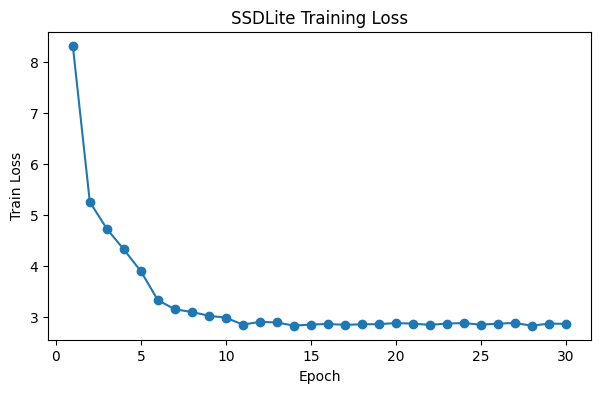

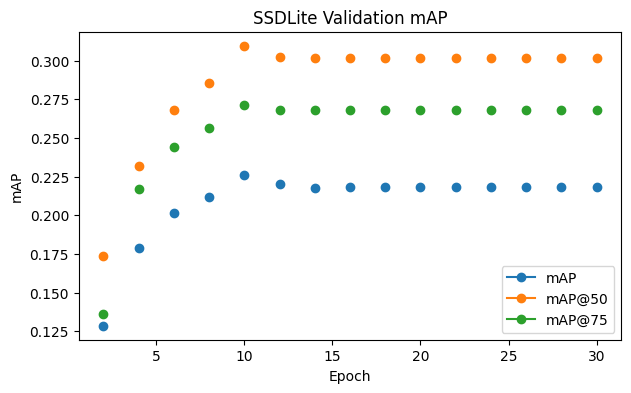

In [21]:
import matplotlib.pyplot as plt
import torch

if "history" not in locals() or not history.get("epoch"):
    if (ssd_out / "last_ssdlite.pt").exists():
        ckpt = torch.load(ssd_out / "last_ssdlite.pt", map_location="cpu")
        history = ckpt.get("history", history)

if history.get("epoch"):
    plt.figure(figsize=(7, 4))
    plt.plot(history["epoch"], history["train_loss"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("SSDLite Training Loss")
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(history["epoch"], history["map"], marker="o", label="mAP")
    plt.plot(history["epoch"], history["map_50"], marker="o", label="mAP@50")
    plt.plot(history["epoch"], history["map_75"], marker="o", label="mAP@75")
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("SSDLite Validation mAP")
    plt.legend()
    plt.show()

Loaded best checkpoint: /home/yukkami/cv/runs/2a_ssdlite/ssd_outputs/best_ssdlite.pt
Val images found: 121
Image: 11f9f599-IMG_6363.jpeg | raw preds: 300


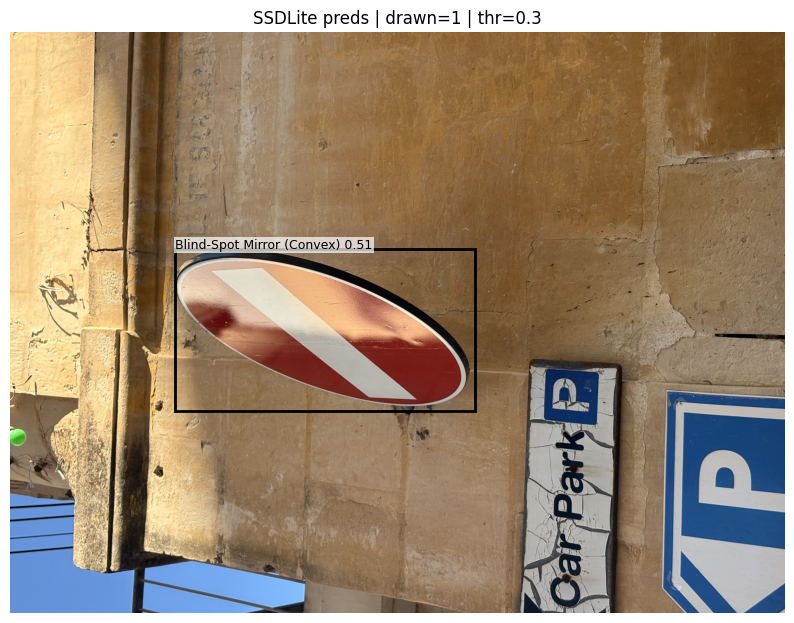

Image: e0513e36-IMG_1327.jpg | raw preds: 300


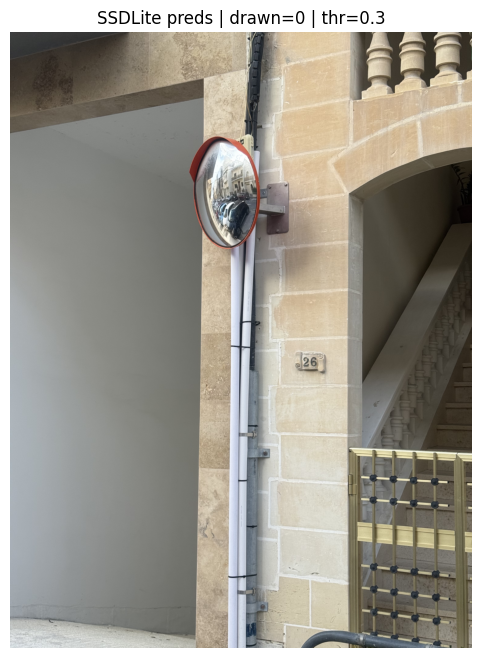

Image: 99b70ab1-Pre_2026_6654.jpg | raw preds: 300


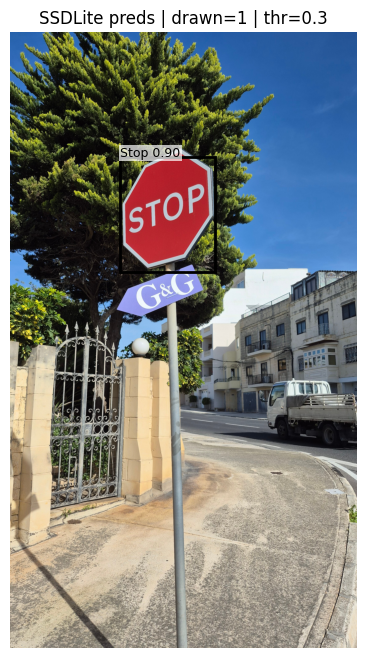

In [22]:
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torchvision

if (ssd_out / "best_ssdlite.pt").exists():
    ckpt = torch.load(ssd_out / "best_ssdlite.pt", map_location=device)
    ssd_model.load_state_dict(ckpt["model_state"])
    ssd_model.to(device).eval()
    print("Loaded best checkpoint:", ssd_out / "best_ssdlite.pt")
else:
    ssd_model.to(device).eval()

def draw_ssd_preds_on_pil(pil_img, outputs, score_thr=0.3, max_draw=30):
    img = pil_img.copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img)
    ax.axis("off")

    boxes = outputs["boxes"].detach().cpu().numpy()
    scores = outputs["scores"].detach().cpu().numpy()
    labels = outputs["labels"].detach().cpu().numpy()

    drawn = 0
    for (x1, y1, x2, y2), s, lab in zip(boxes, scores, labels):
        if s < score_thr:
            continue
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, fill=False)
        ax.add_patch(rect)
        name = contig_to_name.get(int(lab), str(int(lab)))
        ax.text(x1, max(0, y1 - 3), f"{name} {float(s):.2f}", fontsize=9,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1))
        drawn += 1
        if drawn >= max_draw:
            break

    ax.set_title(f"SSDLite preds | drawn={drawn} | thr={score_thr}", fontsize=12)
    plt.show()

with open(val_json_path, "r", encoding="utf-8") as f:
    val_coco = json.load(f)

val_paths = []
for im in val_coco["images"]:
    fn = im["file_name"]
    p = IMAGES_DIR / fn
    if not p.exists():
        p = IMAGES_DIR / Path(fn).name
    if p.exists():
        val_paths.append(p)

print("Val images found:", len(val_paths))
assert len(val_paths) > 0

for _ in range(3):
    img_path = random.choice(val_paths)
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = torchvision.transforms.functional.to_tensor(pil_img).to(device)

    with torch.no_grad():
        out = ssd_model([img_tensor])[0]

    print("Image:", img_path.name, "| raw preds:", out["boxes"].shape[0])
    draw_ssd_preds_on_pil(pil_img, out, score_thr=0.3)